# Classification d'images

## Importer TensorFlow et d'autres bibliothèques

In [58]:
# import pathlib
# import os
# import PIL

import matplotlib.pyplot as plt
import numpy as np

import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Input, Rescaling, Conv2D, MaxPooling2D, Dropout, Flatten, Dense, RandomFlip, RandomRotation, RandomZoom

## Chargement des données

In [59]:
batch_size = 32
img_height = 180
img_width = 180

folderName = 'datasets/'

# Données d'entrainement (X)
X_train = keras.utils.image_dataset_from_directory(
  folderName,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

# Données de validation (Y)
val_ds = keras.utils.image_dataset_from_directory(
  folderName,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)


class_names = X_train.class_names
print(class_names)

Found 6958 files belonging to 8 classes.
Using 5567 files for training.
Found 6958 files belonging to 8 classes.
Using 1391 files for validation.
['battery', 'biological', 'brown-glass', 'cardboard', 'green-glass', 'metal', 'paper', 'plastic']


## Visualisation des données

2024-03-26 16:00:17.622863: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


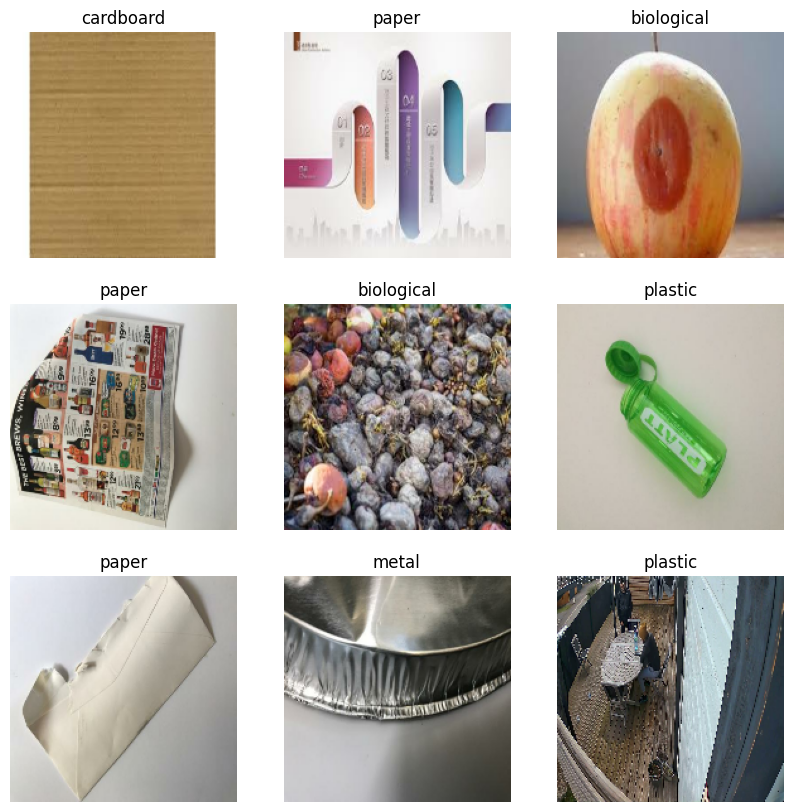

In [60]:
plt.figure(figsize=(10, 10))
for images, labels in X_train.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [61]:
for image_batch, labels_batch in X_train:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 180, 180, 3)
(32,)


## Standardiser les données

In [62]:
# normalization_layer = Rescaling(1./255)

# # Normalisation des données en entrée
# X_train = X_train.map(lambda x, y: (normalization_layer(x), y))
# image_batch, labels_batch = next(iter(X_train))
# first_image = image_batch[0]

# print(np.min(first_image), np.max(first_image)) # Les valeurs de pixel sont désormais entre `[0,1]`.

# # Normalisation des données de validation
# val_ds = val_ds.map(lambda x, y: (normalization_layer(x), y))

## Configurer l'ensemble de données pour les performances

In [63]:
AUTOTUNE = tf.data.AUTOTUNE

X_train = X_train.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

## Création du modèle

In [64]:
# Augmentation virtuelle des données d'entrainement

data_augmentation = Sequential(
  [
    RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    RandomRotation(0.1),
    RandomZoom(0.1),
  ]
)

/home/charles/web/alyra/villepropre/.venv/lib/python3.10/site-packages/keras/src/layers/preprocessing/tf_data_layer.py:18: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2024-03-26 16:00:18.848260: W tensorflow/core/kernels/data/cache_dataset_ops.cc:858] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2024-03-26 16:00:19.443969: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


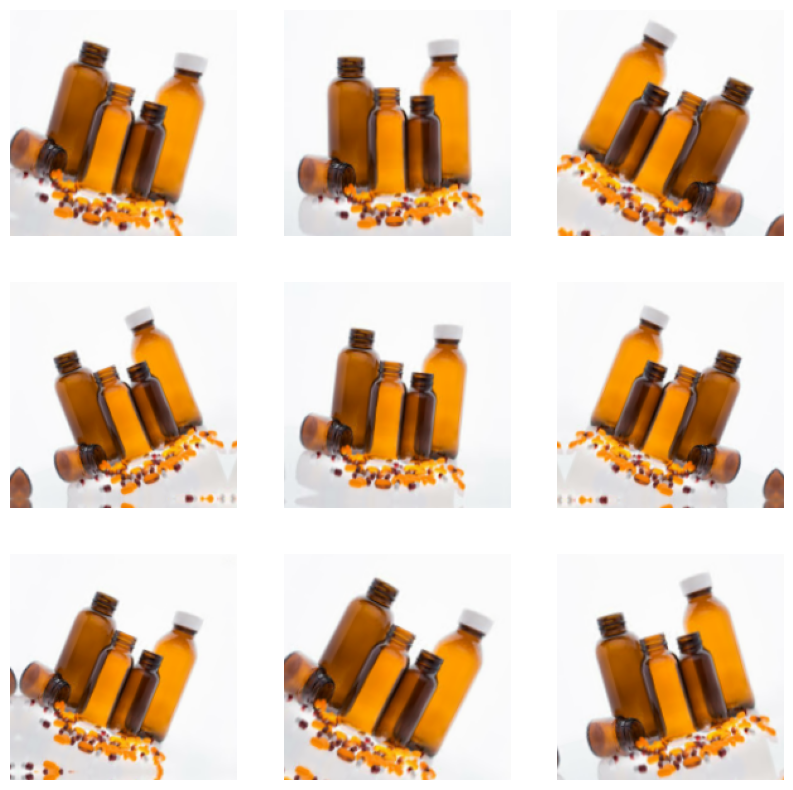

In [65]:
# Visualisation des données "augmentées"
plt.figure(figsize=(10, 10))
for images, _ in X_train.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[10].numpy().astype("uint8"))
    plt.axis("off")

In [66]:
# Nombre de classes d'éléments à détecter
num_classes = len(class_names)

model = Sequential(name="ALYRA-IA-DEV-PROJET-E1-EDOUNZE-CHARLES")

# On définit clairement la forme d'entrée attendue par le modèle. 
# Chaque image d'entrée sera de taille 180x180 avec 3 canaux (couleur RGB).
model.add(Input(shape=(img_height, img_width, 3)))

# Cette couche applique des transformations aléatoires aux images d'entrée (comme la rotation, le zoom, le décalage) 
# pour augmenter la diversité du jeu de données d'entraînement sans avoir besoin de plus d'images. Cela aide le modèle à généraliser mieux à partir de données limitées.
model.add(data_augmentation)

# Cette couche normalise les images d'entrée en divisant les valeurs des pixels par 255. 
# Cela transforme les valeurs de pixels de la plage [0, 255] à [0, 1]
model.add(Rescaling(1./255))

# Première couche de convolution qui applique 128 filtres de 3x3 sur l'image d'entrée pour extraire des caractéristiques de bas niveau comme les bords. 
# La fonction d'activation 'relu' ajoute de la non-linéarité, permettant à la couche d'apprendre des motifs complexes.
model.add(Conv2D(128, 3, activation='relu'))

# Ces couches suivent généralement les couches Conv2D et servent à réduire la dimensionnalité spatiale de la couche Conv2D précédente, en conservant les caractéristiques les plus importantes. 
# Elles aident à rendre le modèle plus efficace et à diminuer le risque de surajustement (overfitting) en extrayant les caractéristiques les plus saillantes.
model.add(MaxPooling2D())
# model.add(MaxPooling2D(pool_size=(2, 2), strides=(3, 3)))

# Deuxième couche de convolution qui applique à nouveau 64 filtres de 3x3. 
# À ce stade, le modèle cherche à extraire des caractéristiques plus complexes à partir des informations simplifiées par la première couche de MaxPooling.
model.add(Conv2D(64, 3, activation='relu'))

# Agit sur la sortie de la deuxième couche Conv2D pour réduire encore la dimensionnalité. 
# Cette étape continue de condenser l'information, permettant au modèle de devenir progressivement plus abstrait et concentré sur les caractéristiques saillantes (remarquables).
# model.add(MaxPooling2D())
model.add(MaxPooling2D(pool_size=(2, 2), strides=(3, 3)))


# Troisième couche de convolution qui applique à nouveau 32 filtres de 3x3. 
# poussant le modèle à extraire et à apprendre des caractéristiques encore plus abstraites des données
model.add(Conv2D(32, 3, activation='relu'))

# Appliquée après la troisième couche Conv2D, cette couche de pooling continue de réduire la dimensionnalité de la représentation de l'image, 
# préparant les données pour une analyse de haut niveau dans les couches suivantes.
# MaxPooling2D()
model.add(MaxPooling2D(pool_size=(2, 2), strides=(3, 3)))

# Cette couche ignore aléatoirement 20% des neurones durant l'entraînement, réduisant ainsi le surajustement en forçant 
# le modèle à apprendre des caractéristiques plus robustes qui ne dépendent pas d'un petit nombre de neurones.
model.add(Dropout(0.2))

# Cette couche aplatie les matrices multidimensionnelles en vecteurs unidimensionnels, 
# permettant de passer de représentations spatiales à un format compatible avec les couches denses.
model.add(Flatten())

# Une couche dense (ou entièrement connectée) qui a 128 neurones et utilise ReLU comme fonction d'activation. 
# Cette couche permet au modèle de combiner les caractéristiques apprises par les couches précédentes pour former des abstractions de plus haut niveau.
model.add(Dense(128, activation='relu'))

# Dernière couche dense avec un nombre de neurones égal au nombre de classes dans le jeu de données. 
# Elle génère la sortie du modèle, où chaque neurone représente la probabilité que l'image d'entrée appartienne à une classe spécifique.
model.add(Dense(num_classes, activation='softmax', name='output'))

In [67]:
model.compile(
  optimizer='adam',
  loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])


Nombre de couches :  10


Model: "ALYRA-IA-DEV-PROJET-E1-EDOUNZE-CHARLES"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential_2 (Sequential)       │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_3 (Rescaling)         │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 178, 178, 128)  │         3,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 89, 89, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 87, 87, 64)     │        73,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 29, 29, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 27, 27, 32)     │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 9, 9, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 9, 9, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 2592)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 128)            │       331,904 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 8)              │         1,032 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 428,776 (1.64 MB)

 Trainable params: 428,776 (1.64 MB)

 Non-trainable params: 0 (0.00 B)

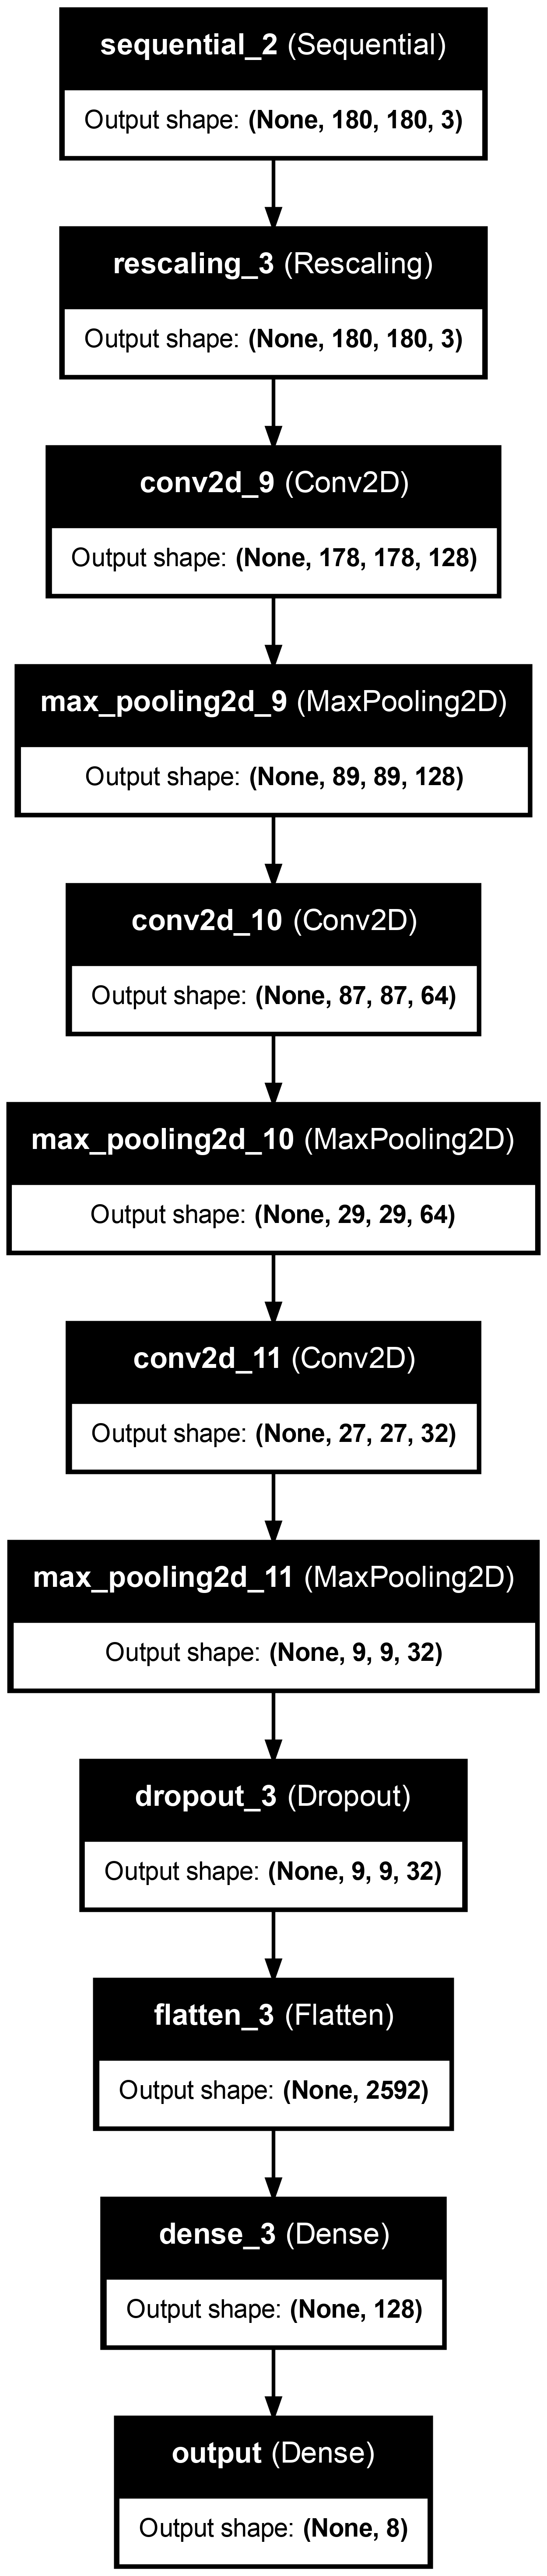

In [68]:
# Détails du modèle
print('Nombre de couches : ', len(model.weights))
model.summary()


# Affichage du modèle
keras.utils.plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True, dpi=300)


## Entrainement du modèle

In [69]:
epochs=25
# callbacks = [
#     keras.callbacks.ModelCheckpoint("save_at_{epoch}.keras"),
# ]

history  = model.fit(
  X_train,  # input data
  validation_data=val_ds,  # target data
  epochs=epochs
  # callbacks=callbacks,
)

Epoch 1/25


/home/charles/web/alyra/villepropre/.venv/lib/python3.10/site-packages/keras/src/backend/tensorflow/nn.py:599: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


174/174 ━━━━━━━━━━━━━━━━━━━━ 284s 2s/step - accuracy: 0.3109 - loss: 1.7903 - val_accuracy: 0.6147 - val_loss: 1.1256
Epoch 2/25
174/174 ━━━━━━━━━━━━━━━━━━━━ 272s 2s/step - accuracy: 0.5853 - loss: 1.1656 - val_accuracy: 0.6585 - val_loss: 0.9993
Epoch 3/25
174/174 ━━━━━━━━━━━━━━━━━━━━ 290s 2s/step - accuracy: 0.6531 - loss: 0.9918 - val_accuracy: 0.6808 - val_loss: 0.9521
Epoch 4/25
174/174 ━━━━━━━━━━━━━━━━━━━━ 292s 2s/step - accuracy: 0.6864 - loss: 0.9018 - val_accuracy: 0.7369 - val_loss: 0.8058
Epoch 5/25
174/174 ━━━━━━━━━━━━━━━━━━━━ 292s 2s/step - accuracy: 0.7141 - loss: 0.8209 - val_accuracy: 0.7469 - val_loss: 0.7516
Epoch 6/25
174/174 ━━━━━━━━━━━━━━━━━━━━ 279s 2s/step - accuracy: 0.7320 - loss: 0.7800 - val_accuracy: 0.7311 - val_loss: 0.7916
Epoch 7/25
174/174 ━━━━━━━━━━━━━━━━━━━━ 282s 2s/step - accuracy: 0.7501 - loss: 0.7166 - val_accuracy: 0.7513 - val_loss: 0.7433
Epoch 8/25
174/174 ━━━━━━━━━━━━━━━━━━━━ 271s 2s/step - accuracy: 0.7531 - loss: 0.7135 - val_accuracy: 0.744

## Résultats de l'entrainement

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(15, 15))
plt.subplot(3, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(3, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## Prédiction de nouvelles données

In [ ]:

def doPrediction(imgToPredict, model=model):
    img_array = keras.utils.img_to_array(imgToPredict)
    img_array = tf.expand_dims(img_array, 0) # Create batch axis

    predictions = model.predict(img_array)
    score = tf.nn.softmax(predictions[0])

    print(
        "This image most likely belongs to {} with a {:.2f} percent confidence."
        .format(class_names[np.argmax(score)], 100 * np.max(score))
    )

    plt.imshow(imgToPredict)
    
object_url = "https://us.123rf.com/450wm/nito500/nito5001011/nito500101100005/8110733-bouteille-en-plastique-%C3%A9cras%C3%A9-isol%C3%A9-sur-un-fond-blanc-sur-un-fond-blanc.jpg"
object_path = keras.utils.get_file('Object_image', origin=object_url)

img = keras.utils.load_img(object_path, target_size=(img_height, img_width))

# Do prediction !
doPrediction(img)


# img_array = keras.utils.img_to_array(img)
# img_array = tf.expand_dims(img_array, 0) # Create batch axis

# predictions = model.predict(img_array)
# score = tf.nn.softmax(predictions[0])

# print(
#     "This image most likely belongs to {} with a {:.2f} percent confidence."
#     .format(class_names[np.argmax(score)], 100 * np.max(score))
# )




## Sauvegarde du modèle

In [ ]:
model.save("models/garbage_detection_model.keras")

## Réutilisation du modèle sauvegardé

In [ ]:
modelSaved = tf.keras.models.load_model("garbage_detection_model.keras")

# loss, acc = modelSaved.evaluate(val_ds)
# print("Restored model, accuracy: {:5.2f}%".format(100 * acc))

# New prediction ! (Inference)
object_url = "https://t3.ftcdn.net/jpg/00/61/65/50/360_F_61655074_7J7dl9Ejn9jDPGAwrurHJWbiT86Tqblo.jpg"
object_path = keras.utils.get_file('Object_image', origin=object_url)

newImg = keras.utils.load_img(object_path, target_size=(img_height, img_width))
doPrediction(newImg, model=modelSaved)